<a href="https://colab.research.google.com/github/imanhamid/selectionscan_NN/blob/master/selectionscan_CNN_firstpass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading in the data

Be sure to set runtime to GPU before executing code!!

In [ ]:
from fastai.vision import *

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [ ]:
classes = ["selection", "neutral"]

First, create a folder in Google Drive where you will put the images. I put mine in "/content/gdrive/My Drive/fastai-v3/data/sweeps". Within that "sweeps" directory, I uploaded neutral and sweep images to "./selection" and "./neutral". These directory names can correspond to the classification labels (this will make labeling easier in the next step).

In [ ]:
path = Path(base_dir + 'data/sweeps')

In [ ]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/data/sweeps/selection'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/sweeps/neutral')]

Next, we load in the data, creating an ImageList from the folder names (which correspond to the classification labels). I set the batch size to 16 because the images are decently sized.

I transformed the size to 224x224, but it didn't really change the accuracy much.

In [ ]:
data=(ImageList.from_folder(path)
  .split_by_rand_pct()
  .label_from_folder()
  .transforms(size=224)
  .databunch(bs=16))

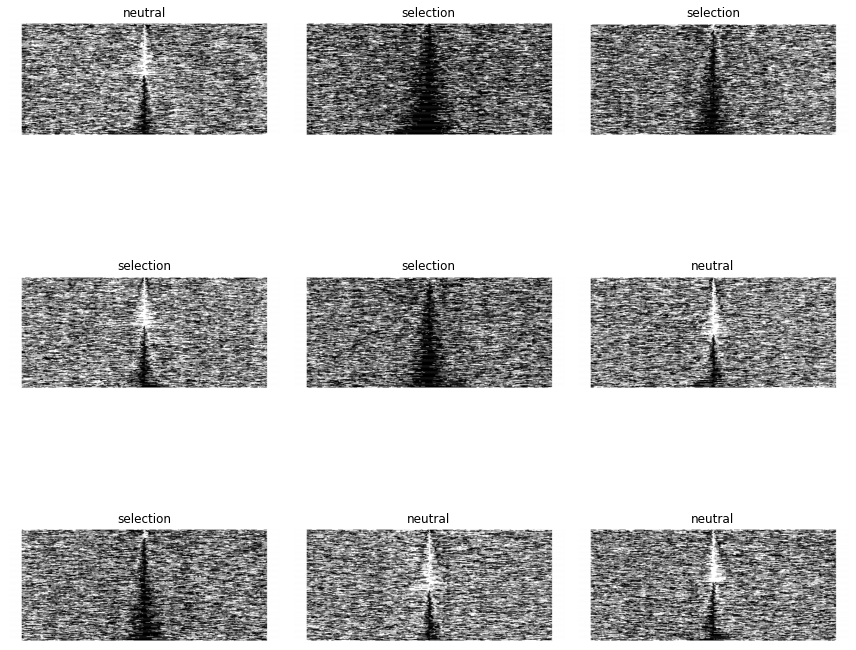

In [ ]:
data.show_batch(rows=3)

In [ ]:
print(data.classes)

['neutral', 'selection']


# Train the model

I used resnet18 because that was originally used for the MNIST dataset. Since this dataset was relatively simple, I figured it would be enough for this test set, and would likely train the quickest.

In [ ]:
learner = cnn_learner(data, models.resnet18, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


Train the top layers for 4 epochs.

In [ ]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.500536,0.280524,0.910000,10:25
1,0.343277,0.229432,0.932500,01:30
2,0.230496,0.217713,0.935000,01:30
3,0.158521,0.206253,0.937500,01:30


In [ ]:
learner.save('stage-1')

In [ ]:
Try to find a better learning rate??

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


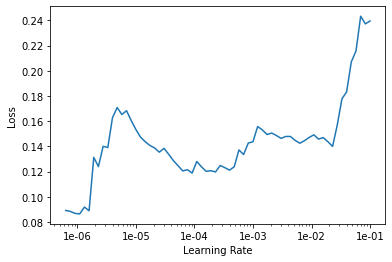

In [ ]:
learner.recorder.plot()

I really don't know what to make of this LR plot, so I just went with the lowest point, before the loss started to increase.

Next, we unfreeze the lower layers, and train those for 4 epochs. It didn't actually improve the accuracy...

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(5, max_lr=slice(1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.123539,0.205964,0.940000,02:05
1,0.118277,0.208622,0.937500,02:04
2,0.111278,0.208158,0.937500,02:04
3,0.097147,0.208541,0.937500,02:03
4,0.114951,0.207795,0.937500,02:03


# Interpretation

Here, I was really just looking around to see what's inside the ClassificationInterpretation object.

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

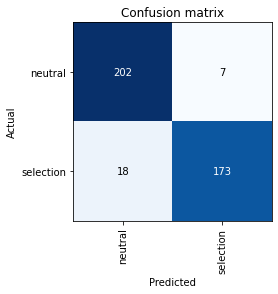

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
losses,  idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

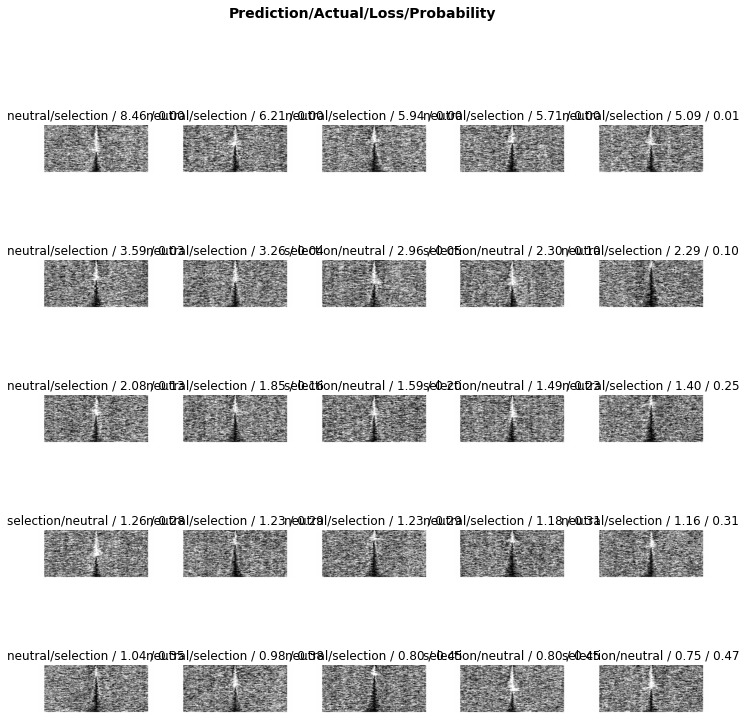

In [ ]:
interp.plot_top_losses()

In [ ]:
interp.pred_class, interp.y_true

(tensor([0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
         1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
         0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
         0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
         0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
         0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
         0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
         1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
         0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
         0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
         0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
         1, 1, 0, 0, 0, 0, 0

In [ ]:
interp.data

ImageDataBunch;

Train: LabelList (1600 items)
x: ImageList
Image (3, 500, 1200),Image (3, 500, 1200),Image (3, 500, 1200),Image (3, 500, 1200),Image (3, 500, 1200)
y: CategoryList
selection,selection,selection,selection,selection
Path: /content/gdrive/My Drive/fastai-v3/data/sweeps;

Valid: LabelList (400 items)
x: ImageList
Image (3, 500, 1200),Image (3, 500, 1200),Image (3, 500, 1200),Image (3, 500, 1200),Image (3, 500, 1200)
y: CategoryList
neutral,selection,neutral,selection,selection
Path: /content/gdrive/My Drive/fastai-v3/data/sweeps;

Test: None

List of all the filenames in the validation set (if you want to plot or calculate accuracy on your own, this will be helpful!)

In [ ]:
num = len(learner.data.valid_ds)

In [ ]:
for i in range(num):
  print(str(learner.data.valid_ds.items[i]).split('/')[-1])

const-10000_single-pulse_gen-100_m-0.5_s-0_seed-748_alltracts.png
const-10000_single-pulse_gen-100_m-0.5_t-1_s-0.199849891103804_seed-923_alltracts.png
const-10000_single-pulse_gen-100_m-0.5_s-0_seed-676_alltracts.png
const-10000_single-pulse_gen-100_m-0.5_t-1_s-0.00598447448574007_seed-357_alltracts.png
const-10000_single-pulse_gen-100_m-0.5_t-1_s-0.0819031291641295_seed-948_alltracts.png
const-10000_single-pulse_gen-100_m-0.5_t-1_s-0.0214378556236625_seed-752_alltracts.png
const-10000_single-pulse_gen-100_m-0.5_s-0_seed-742_alltracts.png
const-10000_single-pulse_gen-100_m-0.5_t-1_s-0.0877378512173891_seed-673_alltracts.png
const-10000_single-pulse_gen-100_m-0.5_t-1_s-0.0157977275084704_seed-935_alltracts.png
const-10000_single-pulse_gen-100_m-0.5_s-0_seed-131_alltracts.png
const-10000_single-pulse_gen-100_m-0.5_t-1_s-0.188749446859583_seed-185_alltracts.png
const-10000_single-pulse_gen-100_m-0.5_s-0_seed-70_alltracts.png
const-10000_single-pulse_gen-100_m-0.5_t-1_s-0.15637782709673_s

Extract predicted probability of sweep/neutral variant for each validation sample. Order of classes is based on the list we specified earlier.

In [ ]:
interp.preds, interp.preds[:,1]

(tensor([[7.1017e-01, 2.8983e-01],
         [2.3410e-04, 9.9977e-01],
         [9.9868e-01, 1.3249e-03],
         [9.9387e-01, 6.1312e-03],
         [1.1304e-02, 9.8870e-01],
         [7.0781e-01, 2.9219e-01],
         [9.9975e-01, 2.5329e-04],
         [1.1054e-02, 9.8895e-01],
         [7.2608e-02, 9.2739e-01],
         [4.4953e-01, 5.5047e-01],
         [2.3804e-05, 9.9998e-01],
         [8.2035e-01, 1.7965e-01],
         [5.0924e-04, 9.9949e-01],
         [9.7307e-01, 2.6928e-02],
         [9.7486e-01, 2.5142e-02],
         [9.9807e-01, 1.9305e-03],
         [9.9958e-01, 4.1544e-04],
         [1.6371e-03, 9.9836e-01],
         [9.5460e-05, 9.9990e-01],
         [7.4426e-01, 2.5574e-01],
         [9.3535e-01, 6.4652e-02],
         [6.4204e-04, 9.9936e-01],
         [1.0486e-03, 9.9895e-01],
         [1.1949e-04, 9.9988e-01],
         [6.5735e-04, 9.9934e-01],
         [9.9887e-01, 1.1258e-03],
         [9.7591e-01, 2.4092e-02],
         [9.9952e-01, 4.7606e-04],
         [9.9966e-01